In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

from scipy import signal


In [2]:
z = 20
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [3]:
class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)
        if behavior == 'dRotLabY':
            self.fictrac_smoothed_Y = fictrac_smoothed
        if behavior == 'dRotLabZ':
            self.fictrac_smoothed_Z = fictrac_smoothed
            
        # raw fictrac data
        fictrac_smoothed = np.asarray(self.fictrac_raw[behavior])
        if behavior == 'dRotLabY':
            self.fictrac_Y = fictrac_smoothed
        if behavior == 'dRotLabZ':
            self.fictrac_Z = fictrac_smoothed
            
        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object
    
    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)

            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1

            ### Strongly Clipped Velocities ###
            # excludes points even close to 0
            #self.fictrac[short + '_pos_very'] = np.clip(self.fictrac[short], a_min=0.3, a_max=None)
            #self.fictrac[short + '_neg_very'] = np.clip(self.fictrac[short], a_min=None, a_max=-0.3)*-1

            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior#/np.std(high_res_behavior)
            
            self.fictrac[short + 'h_pos'] = np.clip(high_res_behavior, a_min=0, a_max=None)
            self.fictrac[short + 'h_neg'] = np.clip(high_res_behavior, a_min=None, a_max=0)*-1

#           ### Acceleration ###
            temp = np.diff(self.fictrac[short + 'h_pos'])
            temp = np.append(temp, 0) #need to add a single value that was removed
            self.fictrac[short + 'ah_pos_plus'] = np.clip(temp, a_min=0, a_max=None)
            self.fictrac[short + 'ah_pos_minus'] = np.clip(temp, a_min=None, a_max=0)*-1

            temp = np.diff(self.fictrac[short + 'h_neg'])
            temp = np.append(temp, 0) #need to add a single value that was removed
            self.fictrac[short + 'ah_neg_plus'] = np.clip(temp, a_min=0, a_max=None)
            self.fictrac[short + 'ah_neg_minus'] = np.clip(temp, a_min=None, a_max=0)*-1
            
#             accel = scipy.signal.savgol_filter(np.diff(high_res_behavior),25,3)
#             accel = np.append(accel, 0)
#             interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
#             acl = interp_object(self.timestamps[:,z])
#             acl[-1] = 0
#             self.fictrac[short + 'a'] = acl#/np.std(acl)

#             ### Clipped Acceleration ###
#             self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
#             self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

            

        self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
        self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

In [4]:
###################
### Build Flies ###
###################
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac(z)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 54.33 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.31 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 53.58 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.29 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 34.53 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.36 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 47.88 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.33 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 47.50 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 10.49 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 126.

In [5]:
len(fly_names)

9

In [6]:
#will be shape (90000, 9, 2, 2)
final_array = np.zeros((90000,9,2,2))

for i,fly in enumerate(fly_names):
    final_array[:,i,0,0] = flies[fly].fictrac.fictrac_Y
    final_array[:,i,1,0] = flies[fly].fictrac.fictrac_Z
    final_array[:,i,0,1] = flies[fly].fictrac.fictrac_smoothed_Y
    final_array[:,i,1,1] = flies[fly].fictrac.fictrac_smoothed_Z

In [7]:
save_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210127_behavior_for_shaul"
np.save(save_file,final_array)

(1000, 1010)

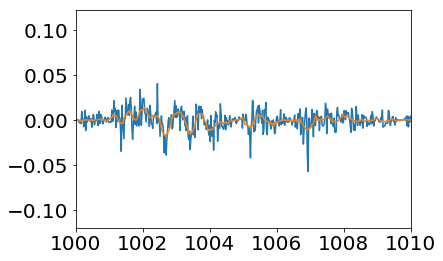

In [53]:
plt.plot(x_original, final_array[:,1,0,0])
plt.plot(x_original, final_array[:,1,0,1])
plt.xlim(1000,1010)


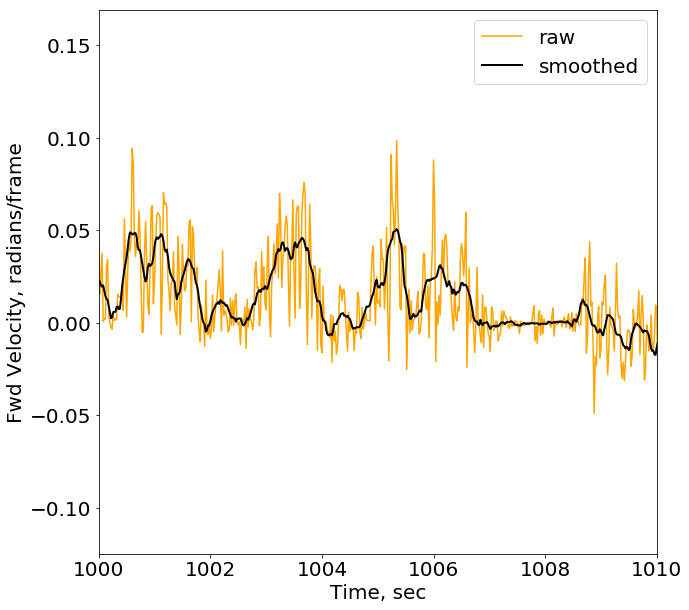

In [46]:
fps=50
camera_rate = 1/fps # camera frame rate in ms
expt_len = 30*60
x_original = np.arange(0,expt_len,camera_rate)

plt.figure(figsize=(10,10))

plt.plot(x_original, flies['fly_087'].fictrac.fictrac_Y,label='raw',color='orange')
plt.plot(x_original, flies['fly_087'].fictrac.fictrac_smoothed_Y,label='smoothed',color='k',linewidth=2)
plt.xlim(1000,1010)
plt.legend()
plt.xlabel('Time, sec')
plt.ylabel('Fwd Velocity, radians/frame')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [47]:
len(flies['fly_087'].fictrac.fictrac_Y)

90000

In [37]:
60*30

1800

In [11]:
len(flies[fly].fictrac.fictrac['Zh'])

180000

In [ ]:
ypos = []
zpos = []
zneg = []
for i, fly in enumerate(fly_names):
    cluster_indicies = flies[fly].cluster_indicies[cluster_num]
    z_map = flies[fly].z_correction[:,:,z].ravel()
    original_z = int(np.median(z_map[cluster_indicies]))
    flies[fly].fictrac.interp_fictrac(original_z)
    ypos.extend(flies[fly].fictrac.fictrac['Y_pos'])
    zpos.extend(flies[fly].fictrac.fictrac['Z_pos'])
    zneg.extend(flies[fly].fictrac.fictrac['Z_neg'])

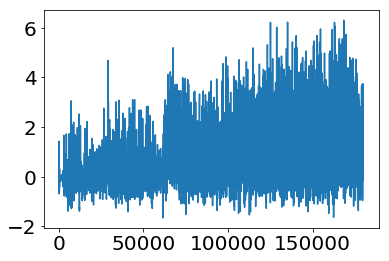

In [11]:
plt.plot(flies['fly_087'].fictrac.fictrac['Yh'])

In [27]:
flies[fly].fictrac.fictrac['Zh_pos'].shape

(180000,)

In [29]:
flies[fly].fictrac.fictrac.keys()

dict_keys(['Yi', 'Y', 'Y_pos', 'Y_neg', 'Yh', 'Yh_pos', 'Yh_neg', 'Ya', 'Ya_pos', 'Ya_neg', 'Zi', 'Z', 'Z_pos', 'Z_neg', 'Zh', 'Zh_pos', 'Zh_neg', 'Za', 'Za_pos', 'Za_neg', 'YZ', 'YZh'])

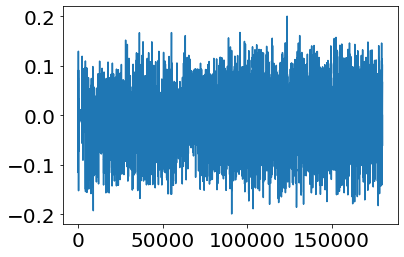

In [46]:
plt.plot(flies['fly_087'].fictrac.fictrac['Zh'])

In [6]:
###########################
### Create Notch Filter ###
###########################

fs = 50.0  # Sample frequency (Hz)
f0 = 1.8797  # Frequency to be removed from signal (Hz)
Q = .2  # Quality factor <---- IMPORTANT
w0 = f0/(fs/2)  # Normalized Frequency

# Design notch filter
b_notch, a_notch = signal.iirnotch(w0, Q)

# Frequency response
w, h = signal.freqz(b_notch, a_notch)

# Generate frequency axis
freq = w*fs/(2*np.pi)

In [7]:
fly_names_subset = [fly_names[i] for i in[0,4,6,7,8]]

In [8]:
fly_names_subset

['fly_087', 'fly_098', 'fly_100', 'fly_101', 'fly_105']

In [9]:
len(flies['fly_087'].fictrac.fictrac['Zh'])

180000

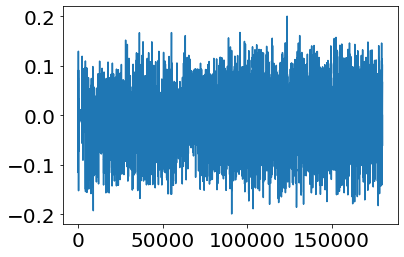

In [12]:
plt.plot(flies['fly_087'].fictrac.fictrac['Zh'])

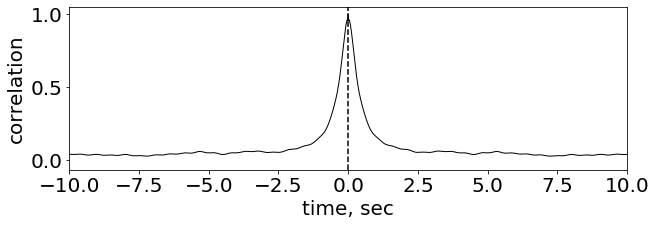

In [25]:
plt.figure(figsize=(10,3))


outs = []
for fly in fly_names_subset:
    #Peak before 0 means a comes first
    #a=np.clip(flies[fly].fictrac.fictrac['Zh'],0,None)
    a=flies[fly].fictrac.fictrac['Zh']
    a=a-np.mean(a)
    
    #b = scipy.signal.savgol_filter(np.append(np.diff(np.clip(flies[fly].fictrac.fictrac['Yh_pos'],0,None)),0),25,3) #accel
    #b=np.clip(flies[fly].fictrac.fictrac['Zh'],0,None)
    b=flies[fly].fictrac.fictrac['Zh']
    b=b-np.mean(b)
    out = scipy.signal.correlate(a,b,mode='same')/len(a)
    out = out/np.max(out)
    outs.append(out)
    
    middle=len(a)/2
    window=15000

    #plt.plot(np.arange(-window*10,window*10,10), out[int(middle-window):int(middle+window)],label=fly,color='grey')

    plt.xlabel('time, sec')
    plt.ylabel('correlation')

out = np.mean(np.asarray(outs),axis=0)
out = signal.filtfilt(b_notch, a_notch, out)
plt.plot(np.arange(-window*10,window*10,10)/1000, out[int(middle-window):int(middle+window)]/np.max(out),color='k',linewidth=1,label='avg')

#plt.legend()
#plt.title('angular velocity auto-correlation')
plt.axvline(0,linestyle='--',color='k')

plt.xlim(-10,10)

#plt.axhline(0,color='grey',linewidth=5)
#plt.axvline(-3000)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')


In [31]:
len(flies[fly].fictrac.fictrac['Zh'])

180000

In [30]:
#10ms bins, 30sec would be 5*30


12000

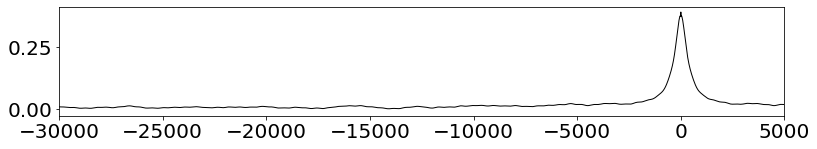

In [76]:
plt.figure(figsize=(13,2))

#plt.plot(out[int(middle-window):int(middle+window)],color='k',linewidth=3,label='avg')
plt.plot(np.arange(-window*10,window*10,10), out[int(middle-window):int(middle+window)],color='k',linewidth=1,label='avg')

plt.xlim(-30000,5000)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight',transparent=True)

In [54]:
out.shape

(180000,)

In [56]:
#10ms units
#90000 is middle
# so 30sec is 30*100 (3000)
# 5sec is 500
out

90000.0

In [58]:
len(np.arange(-window*10,window*10,10))

30000

In [ ]:
#3000 10ms samples is 30sec

In [84]:
temp = interp1d(np.arange(6000),out[90000-3000:90000+3000])
downsampled = temp(np.arange(0,6000,2))

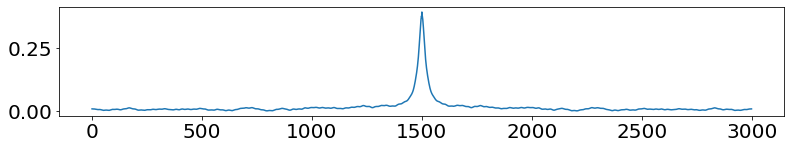

In [87]:
plt.figure(figsize=(13,2))
plt.plot(downsampled)



In [88]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"
save_file = os.path.join(cluster_dir, '20230516_autocorr')
np.save(save_file, downsampled)

In [ ]:
intobj = interp1d(np.arange(-window*10,window*10,10), out[int(middle-window):int(middle+window)], bounds_error = False)



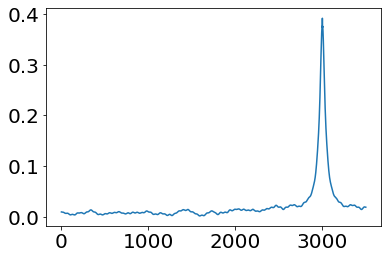

In [57]:
plt.plot(out[90000-3000:90000+500])

In [ ]:
[15000-12000:15000+12000]

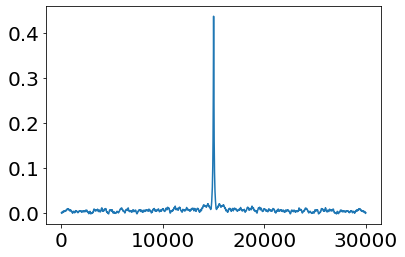

In [12]:
plt.plot(out[int(middle-window):int(middle+window)])

In [ ]:
out[int(middle-window):int(middle+window)]

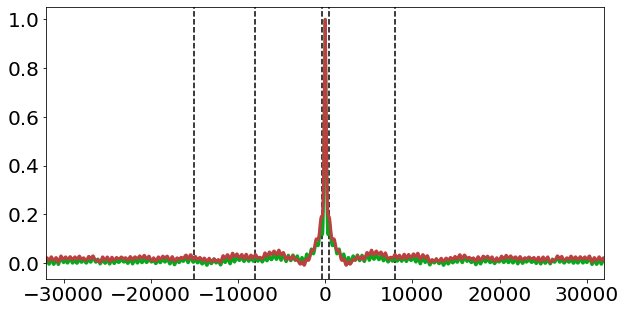

In [50]:
plt.figure(figsize=(10,5))

for line in [-15,-8,-.4,.4,8]:
    plt.axvline(line*1000,color='k',linestyle='--')

### FWD
outs = []
for fly in fly_names:
    #a=np.clip(flies[fly].fictrac.fictrac['Yh'],None,0)
    a=flies[fly].fictrac.fictrac['Yh']
    a=a-np.mean(a)
    
    #b=np.clip(flies[fly].fictrac.fictrac['h'],None,0)
    b=flies[fly].fictrac.fictrac['Yh']
    b=b-np.mean(b)
    out = scipy.signal.correlate(a,b,mode='same')/len(a)
    #out = out/np.max(out)
    outs.append(out)
    
    middle=len(a)/2
    window=15000
out = np.mean(np.asarray(outs),axis=0)
#out = signal.filtfilt(b_notch, a_notch, out)
out = out/np.max(out)
#plt.plot(np.arange(-window*10,window*10,10), out[int(middle-window):int(middle+window)],color='blue',linewidth=2,label='avg')


### LEFT TURNS
outs = []
for fly in fly_names:
    a=np.clip(flies[fly].fictrac.fictrac['Zh'],0,None)
    a=flies[fly].fictrac.fictrac['Zh']
    a=a-np.mean(a)
    
    b=np.clip(flies[fly].fictrac.fictrac['Zh'],0,None)
    b=flies[fly].fictrac.fictrac['Zh']
    b=b-np.mean(b)
    out = scipy.signal.correlate(a,b,mode='same')/len(a)
    #out = out/np.max(out)
    outs.append(out)
    
    middle=len(a)/2
    window=15000
out = np.mean(np.asarray(outs),axis=0)
#out = signal.filtfilt(b_notch, a_notch, out)
out = out/np.max(out)
plt.plot(np.arange(-window*10,window*10,10), out[int(middle-window):int(middle+window)],color='#0AA71D',linewidth=3,label='avg')

### RIGHT TURNS
outs = []
for fly in fly_names:
    a=np.clip(flies[fly].fictrac.fictrac['Zh'],None,0)
    #a=flies[fly].fictrac.fictrac['Yh']
    a=a-np.mean(a)
    
    b=np.clip(flies[fly].fictrac.fictrac['Zh'],None,0)
    #b=flies[fly].fictrac.fictrac['Yh']
    b=b-np.mean(b)
    out = scipy.signal.correlate(a,b,mode='same')/len(a)
    #out = out/np.max(out)
    outs.append(out)
    
    middle=len(a)/2
    window=15000
out = np.mean(np.asarray(outs),axis=0)
#out = signal.filtfilt(b_notch, a_notch, out)
out = out/np.max(out)
plt.plot(np.arange(-window*10,window*10,10), out[int(middle-window):int(middle+window)],color='#BB4141',linewidth=3,label='avg')

#plt.axvspan(-14000, -8000, alpha=0.5, color='grey')
#plt.axvline(0,color='grey',linestyle=(0,(2,2)),lw=3)
#plt.axhline(0,color='grey',linestyle=(0,(2,2)),lw=3)
plt.xlim(-32000,32000)
#plt.axhline(0,color='grey',linewidth=5)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')


(-30000, 30000)

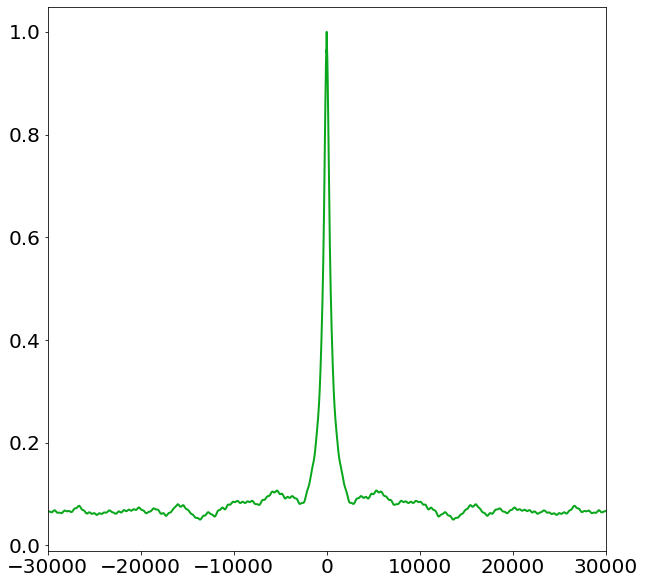

In [55]:
plt.figure(figsize=(10,10))

### LEFT TURNS
a_s = []
b_s = []
for fly in fly_names:
    a=np.clip(flies[fly].fictrac.fictrac['Zh'],0,None)
    a=flies[fly].fictrac.fictrac['Zh']
    #a=a-np.mean(a)
    
    b=np.clip(flies[fly].fictrac.fictrac['Zh'],0,None)
    b=flies[fly].fictrac.fictrac['Zh']
    #b=b-np.mean(b)
    #out = scipy.signal.correlate(a,b,mode='same')/len(a)
    #out = out/np.max(out)
    #outs.append(out)
    a_s.extend(a)
    b_s.extend(b)

a_s = a_s-np.mean(a_s)
b_s = b_s-np.mean(b_s)
out = scipy.signal.correlate(a_s,b_s,mode='same')/len(a_s)
middle=len(a_s)/2
window=15000


#out = np.mean(np.asarray(outs),axis=0)
out = signal.filtfilt(b_notch, a_notch, out)
out = out/np.max(out)
plt.plot(np.arange(-window*10,window*10,10), out[int(middle-window):int(middle+window)],color='#0AA71D',linewidth=2,label='avg')
plt.xlim(-30000,30000)

In [54]:
np.arange(-window*10,window*10,10)

array([-150000, -149990, -149980, ...,  149970,  149980,  149990])

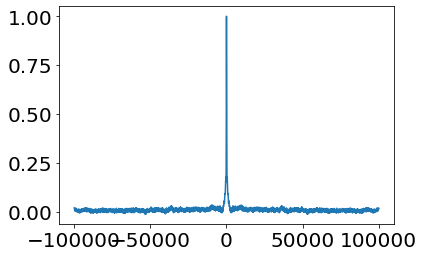

In [38]:
plt.plot(np.arange(-window*10,window*10,10),out[int(middle-window):int(middle+window)])

In [48]:
intobj = interp1d(np.arange(-window*10,window*10,10), out[int(middle-window):int(middle+window)], bounds_error = False)

In [49]:
beh_xs = np.arange(-30000,30000,20)

In [50]:
lowres_auto_corr = intobj(beh_xs)

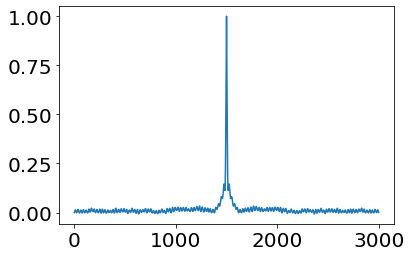

In [51]:
plt.plot(lowres_auto_corr)

In [52]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/20230306_turn_autocorr'
np.save(save_file,lowres_auto_corr)

In [20]:
sine_wave = np.sin(np.arange(0,2*np.pi,.1))
sine_wave = np.repeat(sine_wave,10)
sine_wave = np.concatenate((np.zeros(485), sine_wave, np.zeros(485)))
sine_wave.shape

(1600,)

In [134]:
sine_wave = np.sin(np.arange(0,2*np.pi,.1))
sine_wave = np.repeat(sine_wave,2)
sine_wave = np.concatenate((np.zeros(37), sine_wave, np.zeros(37)))
sine_wave.shape

(200,)

In [132]:
(200-126)/2

37.0

In [124]:
from scipy.fftpack import fft,ifft

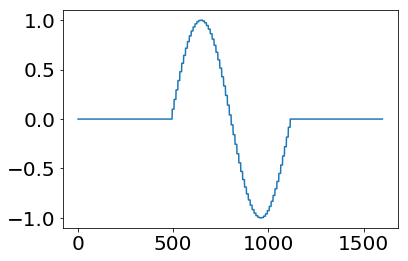

In [123]:
plt.plot(sine_wave)

In [109]:
cc_norm = ifft(fft(sine_wave)/(bot+i))

485.0

In [136]:
window = 100
signal = out[int(middle-window):int(middle+window)]

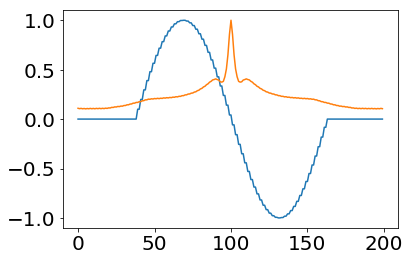

In [137]:
plt.plot(sine_wave)
plt.plot(signal)

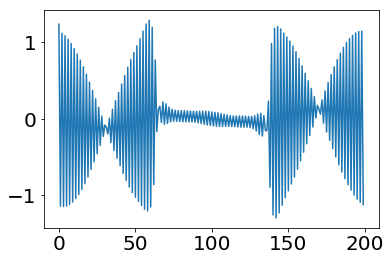

In [145]:
plt.plot(ifft(fft(sine_wave)/fft(signal)+.1))

In [94]:
1600/60

26.666666666666668

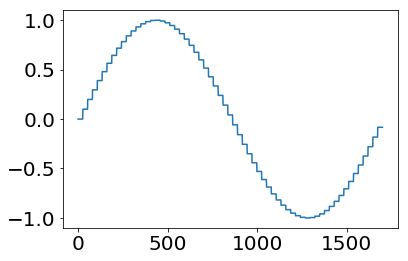

In [95]:
plt.plot(np.repeat(sine_wave,27))

In [75]:
xs = np.arange(-window*10,window*10,10)


(1600,)

In [74]:
out[int(middle-window):int(middle+window)].shape

(1600,)

In [ ]:
list(np.range(-2000,2000,))

In [72]:
np.roll([0,0,1,0,0],1)

array([0, 0, 0, 1, 0])

In [71]:
out = scipy.signal.correlate(a,b,mode='same')/len(a)

In [64]:
90000-np.argmax(out)

-28

In [43]:
out.shape

(180000,)

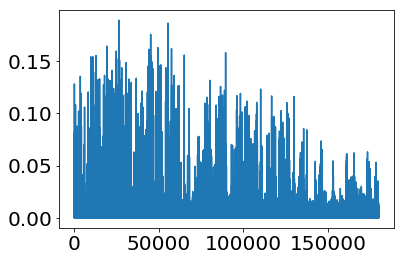

In [33]:
plt.plot(flies[fly].fictrac.fictrac['Zh_neg'])

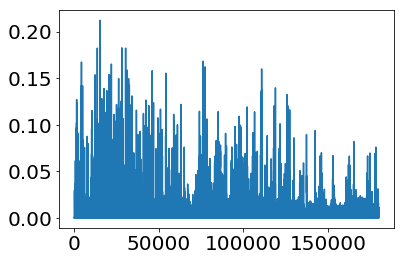

In [34]:
plt.plot(flies[fly].fictrac.fictrac['Zh_pos'])

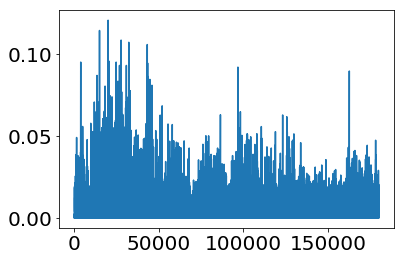

In [35]:
plt.plot(flies[fly].fictrac.fictrac['Yh_pos'])